<h1>Суть задачи:</h1>

Есть лог транзакций клиентов банка.  Со следующими колонками:

client_id  trans_date  small_group  amount_rur

<b>trans_date</b> - в формате кол-ва дней от начала "эксперимента"
<b>small_group</b> - группа, в которую попадает конкретная трата. Всего таких групп 204.

In [277]:
import os
import sys

PROJECT_ROOT = '/'

sys.path.append(PROJECT_ROOT)

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h1>Чтение данных</h1>

Данные разбиваются на трнировочный и валидацонный датасеты. Валидационный будет в последствие использовать 

In [321]:
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import torchvision

class Ds(Dataset):
    
    def __init__(self, data, labels):
        self.data = labels.join(data)
        print(self.data.head(30))
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x = self.data.iloc[index, 1:]
        y = self.data.iloc[index, 0]

        print(self.data.head())
        return torch.tensor(x), torch.tensor(y)

In [278]:
from data_utils import *

conf = {'groups_desc': 'data/small_group_description.csv',
    'train_x': 'data/transactions_train.csv',
    'test_x': 'data/transactions_test.csv',
    'train_target': 'data/train_target.csv',
    'test_target': 'data/test.csv'}

ds = DataSource(conf)
ds.read_data()
ds.validation_split()
print(ds)

train_target = ds.get_data('train_target')
train_target.set_index('client_id', inplace=True)

train_x = ds.get_data('train_x')
valid_x = ds.get_data('valid_x')

valid_target = ds.get_data('valid_target')
valid_target.set_index('client_id', inplace = True)



Reading groups_desc...
Reading train_x...
Reading test_x...
Reading train_target...
Reading test_target...
Validation split: by clientID
Dataset: groups_desc, shape: (204, 2)
Dataset: train_x, shape: (21295142, 4)
Dataset: test_x, shape: (17667328, 4)
Dataset: train_target, shape: (24145, 2)
Dataset: test_target, shape: (20000, 1)
Dataset: valid_x, shape: (5155435, 4)
Dataset: valid_target, shape: (5855, 2)


<b>Пример данных</b>

In [279]:
print(train_x.head())

   client_id  trans_date  small_group  amount_rur
0       3694          26            1      10.006
1       3694          29            3      54.955
2       3694          31            1      10.945
3       3694          34           36      61.721
4       3694          36           25       4.579


<b>Примеры групп:</b>

In [282]:
ds.get_data('groups_desc').head(10)

,small_group,small_group_code
0,Зоотовары,0
1,Сетевые супермаркеты и продуктовые магазины,1
2,Обслуживание существующего автомобиля (АЗС),2
3,Оплата телефона и связи,3
4,Аптеки,4
5,Авиабилеты,5
6,Duty-free,6
7,Страховка,7
8,Спорт,8
9,Универсальные товары,9


<h1>Подход к решению.</h1>

Я пробовал решить задачу используя обычную нейронную сеть. Для этого, выделялись из данных определенные признаки, на которых после обучалась сеть. Как показала практика, сеть, обученная 
на плохих признаках действует примерно аналогично рандому, с точностью 25 процентов. Поэтому выделял наиболее значимые признаки. Подбирал их следующим образом: с помощью группировки смотрел,
какое среднее значение признака для определенной группы. Чем больше разброс между этими значениями, тем лучше фича. При этом для количественных признаков, учитывалось еще и абсолютное значение,
чем больше - тем лучше, потому что в случае небольшого "среднего" числа на группу, для многих клиентов этот признак будет равен 0. А на таких разряженных данных сеть довольно плохо обучается.
Использовал такие фичи:<br/>

1) Максимум, минимум, сумма, среднее всех трат клиента.<br/>
2) Группы с наибольшими тратами<br/>
3) Кол-во "больших" транзакций, т.е. кол-во транзакций с суммой выше порогового значение<br/>
4) Кол-во малых транзакий - меньше парогового значения.<br/>
5) Кол-во транзакций по опредлеленным группам, в качестве групп искал варианты с наибольшим разбросом значенией среди возрастов. <br/>

и др.

Пробовал фичи с привязкой по времени , но особого результата такой подход не дал.

всего было выбрано порядка 20 фич.
    


In [280]:
master_class_group = train_x.groupby(['client_id']).agg(t=('small_group', lambda x: x[x == 86].sum()))
m =  train_target.join(master_class_group).groupby('bins').agg({'t':'mean'})
print(m.head())

              t
bins           
0     37.468760
1     21.035560
2     32.630453
3     44.701286


In [306]:
def prepare_featured_data_v2(df):
    gr1 = df.groupby(['client_id']).agg({'amount_rur':["sum",'max','min','mean',lambda x: x[x > 700].count(),lambda x: x[x < 10].count()],
                                         'trans_date':['count'],
                                            'small_group':['nunique', lambda x: x[x == 4].sum(), lambda x: x[x == 27].sum(),lambda x: x[x == 61].sum(),
                                                          lambda x: x[x == 77].sum(),lambda x: x[x == 86].sum(),
                                                          lambda x: x[x == 8].sum(),lambda x: x[x == 11].sum(),
                                                          lambda x: x[x == 54].sum(),lambda x: x[x == 65].sum(),
                                                          lambda x: x[x == 67].sum()]
                                        })
        
    gr4_by_group = df.groupby(['client_id', 'small_group'], as_index = False)['amount_rur'].agg({'s4':'sum'})
    gr4  = gr4_by_group.loc[gr4_by_group.groupby('client_id')['s4'].idxmin()][['client_id','small_group']]
    gr4.columns = ['client_id', 's4']
    gr4.set_index('client_id', inplace=True)

    
    gr5_by_group = df.groupby(['client_id', 'small_group'], as_index = False)['amount_rur'].agg({'s5':'sum'})
    gr5  = gr5_by_group.loc[gr5_by_group.groupby('client_id')['s5'].idxmax()][['client_id','small_group']]
    gr5.columns = ['client_id', 's5']
    gr5.set_index('client_id', inplace=True)
    
    res = gr1.join(gr4).join(gr5)
    
    res.columns = list(range(1,21))
    res.fillna(0, inplace=True)
    return res
    

In [305]:
from sklearn import preprocessing

def normalize(column_names_to_normalize, df):
    x = df[column_names_to_normalize].values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    
    df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = df.index)
    df[column_names_to_normalize] = df_temp
    return df

In [346]:
from torch import nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.hidden0 = nn.Linear(20, 8)
        self.hidden1 = nn.Linear(8, 16)
        #self.drop = nn.Dropout(0.3)
        
        self.bn1 = nn.BatchNorm1d(8)
        self.bn2 = nn.BatchNorm1d(16)
        self.output = nn.Linear(16, 4)

        
    def forward(self, x):
        x = F.relu(self.bn1(self.hidden0(x)))
        x = F.relu(self.bn2(self.hidden1(x)))
        return F.log_softmax(self.output(x))
        

In [307]:
processed = normalize(list(range(1,21)), prepare_featured_data_v2(train_x))

train_dataset = Ds(data = processed, labels = train_y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  

           bins         1         2         3         4         5         6  \
client_id                                                                     
1046          0  0.007128  0.002887  0.085447  0.006923  0.007949  0.170481   
34089         2  0.004184  0.001817  0.006537  0.004260  0.001590  0.287185   
34848         1  0.002109  0.000135  0.006537  0.001526  0.000000  0.454233   
47076         3  0.001494  0.001214  0.067082  0.001491  0.000000  0.506865   
10938         2  0.002494  0.001216  0.011829  0.001449  0.000000  0.556064   
42965         1  0.006834  0.000979  0.149572  0.004577  0.000000  0.202517   
21594         0  0.004901  0.001277  0.013385  0.004387  0.000000  0.257437   
7952          1  0.006509  0.002905  0.006537  0.006796  0.003180  0.081236   
33810         0  0.004043  0.002122  0.006537  0.004309  0.003180  0.226545   
11061         2  0.002860  0.005940  0.006537  0.002221  0.001590  0.491991   
30905         0  0.002225  0.001221  0.014163  0.002

In [388]:
train_dataset = Ds(data = processed, labels = train_target)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  

valid_dataset = Ds(data = valid_x, labels = valid_target)
total = len(valid_dataset)
valid_loader = DataLoader(valid_dataset, batch_size=total)  

In [358]:
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import torchvision

class Ds(Dataset):
    
    def __init__(self, data, labels):
        self.data = labels.join(data)
        #print(self.data.head(30))
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x = self.data.iloc[index, 1:]
        y = self.data.iloc[index, 0]
        
        return torch.tensor(x.values).float(), torch.tensor(y)

In [409]:
def validateNet(net, loader):
    r, idd = iter(loader).next()
    output = net(r.cuda()).cpu()
    
    pred = output.data.max(1, keepdim=True)[1]
    return float((pred.flatten() == idd).sum().item())/len(pred)

In [410]:
import numpy as np
import torch.optim as optim

learning_rate = 0.001
num_epochs = 20

network = Net().cuda()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

vizualization_data_loss = {}
vizualization_data_acc = {}

for epoch in range(1, num_epochs + 1):
    print('Epoch {}/{}'.format(epoch, num_epochs))
    network.train()
    loss_values = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
            output = network(data.cuda())
            loss = F.cross_entropy(output, target.cuda())
            if(batch_idx % 10 == 0):
                loss_values.append(loss.item())
            
            network.zero_grad()
            loss.backward()
            optimizer.step()
            
    vizualization_data_acc[epoch] = validateNet(network, valid_loader)         
    vizualization_data_loss[epoch] = np.mean(loss_values)


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


In [415]:
from matplotlib import pyplot as plt

def plot_loss(d):
    plt.plot([ k for k in d ], [ v for v in d.values() ])

    plt.title(f'Model acc')
    plt.ylabel('Acc')
    plt.xlabel('Epoch')
    plt.show()


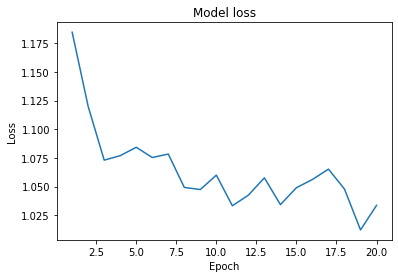

In [396]:
plot_loss(vizualization_data_loss)

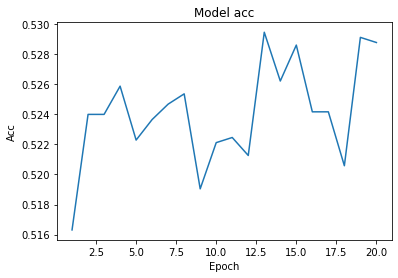

In [416]:
plot_loss(vizualization_data_acc)

In [194]:
print(total)

5855
